In [1]:
import numpy as np
from astropy.coordinates import AltAz, EarthLocation
from astropy.io import fits
import h5py
import healpy as hp
import matplotlib.pyplot as plt

import vis_sim
from croissant.healpix import grid2healpix
from croissant import rotations

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Sky

In [2]:
NSIDE = 64
# NPIX = hp.nside2npix(NSIDE)
# theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX), nest=False, lonlat=False)
# I = np.ones(NPIX)
# Q = -np.cos(2*phi) # + pi?
# U = np.sin(2*phi) # +pi?

In [5]:

with h5py.File("../data/faraday2020v2.hdf5", "r") as f:
    f_depth = f["faraday_sky_mean"][:]  # faraday depth
    
with fits.open("../data/wmap_band_iqumap_r9_9yr_K_v5.fits") as hdul:
    wmap = hdul["Stokes Maps"].data # mK
    I_wmap = wmap["TEMPERATURE"] / 1e3
    Q_wmap = wmap["Q_POLARISATION"] / 1e3
    U_wmap = wmap["U_POLARISATION"] / 1e3
    
# degrade maps
I_wmap = hp.ud_grade(I_wmap, NSIDE, order_in="NEST", order_out="RING")
Q_wmap = hp.ud_grade(Q_wmap, NSIDE, order_in="NEST", order_out="RING")
U_wmap = hp.ud_grade(U_wmap, NSIDE, order_in="NEST", order_out="RING")
f_depth = hp.ud_grade(f_depth, NSIDE)

In [6]:
# generate frequency arrays
fmin = 30e6  # min freq, 30 MHz
bw = 25e3 * 64  # bandwidth
nchan = 64 * 64 # * 10
freq = np.linspace(0, bw, num=nchan) + fmin

In [7]:
sky_gal = np.array([I_wmap, Q_wmap, U_wmap])
sky_gal = sky_gal * (freq.min()/23e9)**(-2.5)  # scale to 30 MHz

# rotate maps, first to equatorial then topocentric
r_g2m = rotations.Rotator(coord="GC")
sky_mcmf = r_g2m.rotate_map_alms(sky_gal, lmax=50)
r_m2t = rotations.Rotator(coord="CT", loc=(182.3, -23.8), time="2024-02-01T22:00") #above horizon
#r_m2t = rotations.Rotator(coord="CT", loc=(182.3, -23.8), time="2024-02-01T02:00")
sky_topo = r_m2t.rotate_map_alms(sky_mcmf, lmax=50)

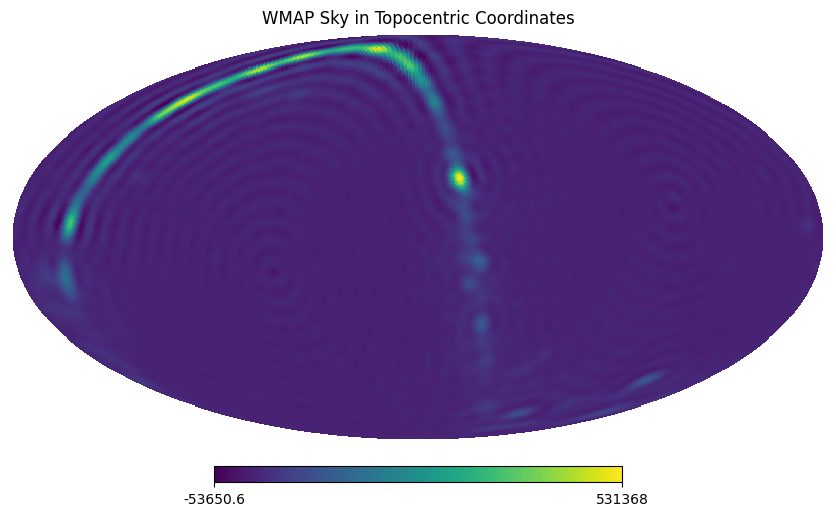

In [8]:
# hp.mollview(I_wmap, title="I")
# hp.mollview(Q_wmap, title="Q")
# hp.mollview(U_wmap, title="U")
hp.mollview(sky_topo[0], title="WMAP Sky in Topocentric Coordinates")
#hp.mollview(sky_gal[0])

### Beam

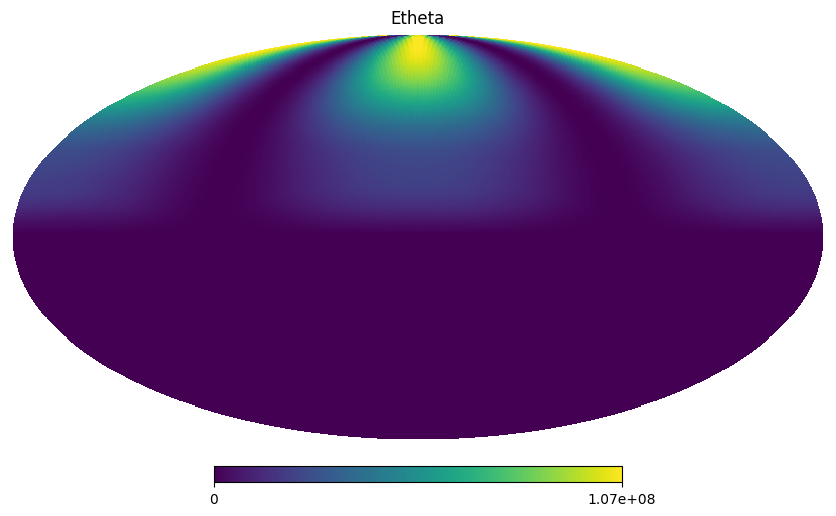

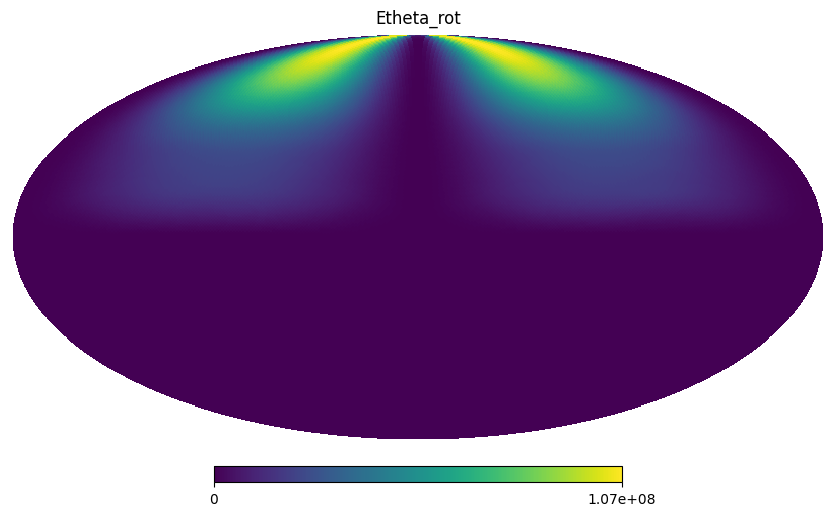

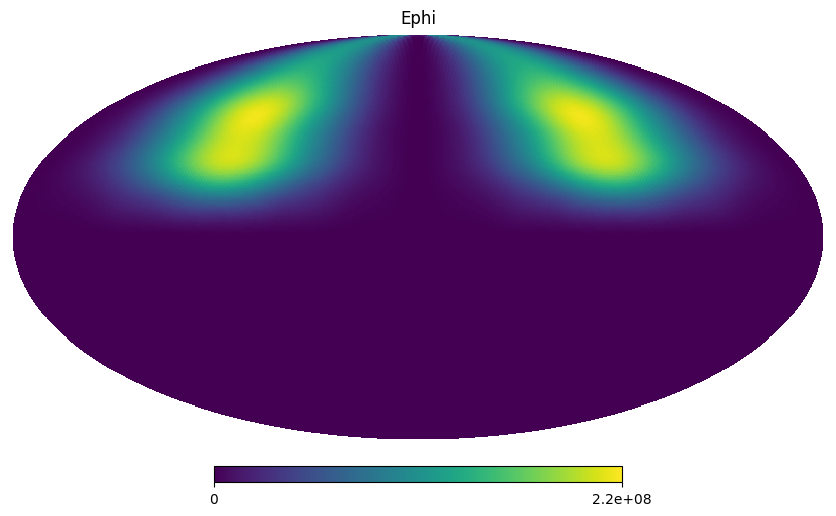

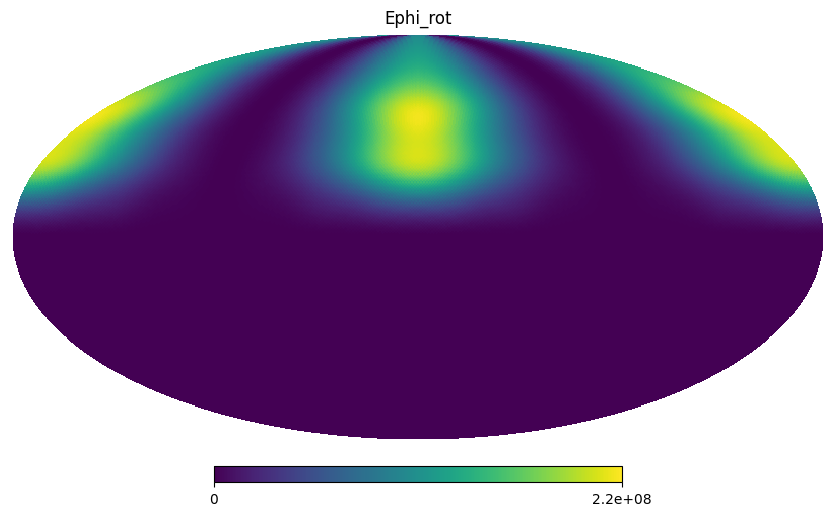

In [10]:
# lusee beam
def read_beam(fname):
    with fits.open(fname) as hdul:
        E_theta = hdul["Etheta_real"].data + 1j * hdul["Etheta_imag"].data
        E_phi = hdul["Ephi_real"].data + 1j * hdul["Ephi_imag"].data
        ix = np.argwhere(hdul["freq"].data == 30)[0, 0]
        E_theta = E_theta[ix]
        E_phi = E_phi[ix]

    lusee_Y = np.array([E_theta.real, E_theta.imag, E_phi.real, E_phi.imag])[:, :, :-1]
    lusee_Y = np.concatenate((lusee_Y, np.zeros_like(lusee_Y)[:, :-1, :]), axis=1)
    #lusee_Y /= np.abs(lusee_Y).max(axis=(1,2))[:, None, None]
    return lusee_Y
    
lusee_Y = read_beam("../data/hfss_lbl_3m_75deg.2port.fits")  # along Y axis
#beam = read_beam("data/feko_bnl_3m_75deg.2port.fits")
lusee_X = np.roll(lusee_Y, -90, axis=-1)
lusee_X = grid2healpix(lusee_X, NSIDE)
lusee_Y = grid2healpix(lusee_Y, NSIDE)

beam_X = np.array([lusee_X[0] + 1j * lusee_X[1], lusee_X[2] + 1j * lusee_X[3]])
beam_Y = np.array([lusee_Y[0] + 1j * lusee_Y[1], lusee_Y[2] + 1j * lusee_Y[3]])

mmin = 0
mmax = 1.07e8

hp.mollview(np.abs(beam_X[0])**2, title="Etheta", min=mmin, max=mmax)
hp.mollview(np.abs(beam_Y[0])**2, title="Etheta_rot", min=mmin, max=mmax)
hp.mollview(np.abs(beam_X[1])**2, title="Ephi", min=mmin, max=2.2e8)
hp.mollview(np.abs(beam_Y[1])**2, title="Ephi_rot", min=mmin, max=2.2e8)

In [11]:
fd_mcmf = r_g2m.rotate_map_alms(f_depth, lmax=50)
fd_topo = r_m2t.rotate_map_alms(fd_mcmf, lmax=50)

In [12]:
stokes = sky_topo
beam = np.array([beam_X, beam_Y])
#RM = 100
RM = fd_topo

In [13]:
def narrow(vis, f):
    return vis[:, :64], f[:64]

def med(vis, f, res=64):
    return vis.reshape(vis.shape[0], -1, res).mean(axis=-1)[:, :64], f.reshape(-1, res).mean(axis=-1)[:64]

def fat(vis, f):
    return vis.reshape(vis.shape[0], -1, 64*64).mean(axis=-1), f.reshape(-1, 64*64).mean(axis=-1)

In [ ]:
RES = 64
sim = vis_sim.Simulator(freq, stokes, RM, beam, healpix=True, nside=NSIDE)
vis = sim.vis(faraday=False, use_spec=False)
vis_rot = sim.vis(faraday=True, use_spec=False)

vis_narrow, f_narrow = narrow(vis, freq)
vis_med, f_med = med(vis, freq, res=RES)

vis_rot_narrow = narrow(vis_rot, freq)[0]
vis_rot_med = med(vis_rot, freq, res=RES)[0]

vis_sim.plot_vis(f_narrow/1e6, vis_narrow, vis_rot_narrow)
vis_sim.plot_vis(f_med/1e6, vis_med, vis_rot_med)

vis_sim.plot_stokes(f_narrow/1e6, vis_sim.vis2stokes(vis_narrow), vis_sim.vis2stokes(vis_rot_narrow))
vis_sim.plot_stokes(f_med/1e6, vis_sim.vis2stokes(vis_med), vis_sim.vis2stokes(vis_rot_med))

In [ ]:
#hp.mollview(sim.RM)

In [ ]:
# stokes I
plt.figure()
plt.plot(vis_sim.vis2stokes(vis)[0])
plt.plot(vis_sim.vis2stokes(vis_rot)[0])
plt.xlim(0, 300)
plt.show()

In [ ]:
print(f_narrow.shape, np.mean(np.diff(f_narrow)))
print(f_med.shape, np.mean(np.diff(f_med)))

In [ ]:
plt.figure()
plt.plot(f_narrow, vis_narrow[0], label="V11")
plt.plot(f_narrow, vis_rot_narrow[0], label="V11 (Faraday)")
plt.plot(f_narrow, vis_narrow[3], label="V22")
plt.plot(f_narrow, vis_rot_narrow[3], label="V22 (Faraday)")
plt.legend()
plt.show()

In [ ]:
I = 1/2*(vis_narrow[0]+vis_narrow[3])
I_rot = 1/2*(vis_rot_narrow[0]+vis_rot_narrow[3])

Q = 1/2*(vis_narrow[0]-vis_narrow[3])
Q_rot = 1/2*(vis_rot_narrow[0]-vis_rot_narrow[3])
U = vis_narrow[1]
U_rot = vis_rot_narrow[1]

plt.figure()
plt.plot(f_narrow, Q / I, label="Q/I")
plt.plot(f_narrow, Q_rot / I_rot, label="Q/I (Faraday)")
plt.legend()
plt.ylim(-0.15, -0.1)
plt.show()

plt.figure()
plt.plot(f_narrow, U / I, label="U/I")
plt.plot(f_narrow, U_rot / I_rot, label="U/I (Faraday)")
plt.legend()
plt.ylim(0.1, 0.15)
plt.show()

In [ ]:
plt.figure()
plt.plot(f_narrow, I, label="I")
plt.plot(f_narrow, I_rot, label="I (Faraday)")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(f_narrow, (Q**2 + U**2) / I**2, label="(Q^2+U^2)/I^2")
plt.plot(f_narrow, (Q_rot**2 + U_rot**2) / I_rot**2, label="(Q^2+U^2)/I^2 (Faraday)")
plt.legend()
plt.ylim(0.0375, 0.04)
plt.show()

change res

In [ ]:
I = 1/2*(vis_med[0]+vis_med[3])
I_rot = 1/2*(vis_rot_med[0]+vis_rot_med[3])

Q = 1/2*(vis_med[0]-vis_med[3])
Q_rot = 1/2*(vis_rot_med[0]-vis_rot_med[3])
U = vis_med[1]
U_rot = vis_rot_med[1]

plt.figure()
plt.plot(f_med, Q / I, label="Q/I")
plt.plot(f_med, Q_rot / I_rot, label="Q/I (Faraday)")
plt.legend()
plt.ylim(-0.15, -0.1)
plt.show()

plt.figure()
plt.plot(f_med, U / I, label="U/I")
plt.plot(f_med, U_rot / I_rot, label="U/I (Faraday)")
plt.legend()
plt.ylim(0.1, 0.15)
plt.show()

In [ ]:
plt.figure()
plt.plot(f_med, I, label="I")
plt.plot(f_med, I_rot, label="I (Faraday)")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(f_med, (Q**2 + U**2) / I**2, label="(Q^2+U^2)/I^2")
plt.plot(f_med, (Q_rot**2 + U_rot**2) / I_rot**2, label="(Q^2+U^2)/I^2 (Faraday)")
plt.legend()
plt.ylim(0.0375, 0.04)
plt.show()